### PREPROCESSING AND MODEL EVALUATION

### Import necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from scipy.stats import randint, uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier  

Load saved csv file

In [2]:
df = pd.read_csv('Telco_Customer_Churn_clean.csv') 

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6913 entries, 0 to 6912
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6913 non-null   object 
 1   gender            6913 non-null   object 
 2   SeniorCitizen     6913 non-null   int64  
 3   Partner           6913 non-null   object 
 4   Dependents        6913 non-null   object 
 5   tenure            6913 non-null   int64  
 6   PhoneService      6913 non-null   object 
 7   MultipleLines     6913 non-null   object 
 8   InternetService   6913 non-null   object 
 9   OnlineSecurity    6913 non-null   object 
 10  OnlineBackup      6913 non-null   object 
 11  DeviceProtection  6913 non-null   object 
 12  TechSupport       6913 non-null   object 
 13  StreamingTV       6913 non-null   object 
 14  StreamingMovies   6913 non-null   object 
 15  Contract          6913 non-null   object 
 16  PaperlessBilling  6913 non-null   object 


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,6913.000000,6913.000000,6913.000000,6913.000000
mean,0.159988,31.797772,64.056575,2203.584992
std,0.366622,24.412594,29.887460,2210.226419
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,8.000000,34.800000,385.900000
50%,0.000000,28.000000,70.050000,1357.100000
75%,0.000000,54.000000,89.300000,3597.500000
max,1.000000,72.000000,118.750000,8672.450000


In [7]:
# Step 2: Define features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                        'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [8]:
# Separate the target variable (Churn) into a new Series
y = df['Churn'].map({'No': 0, 'Yes': 1})

# Create a feature matrix (X) by dropping 'Churn' and 'customerID' columns
X = df.drop(['Churn', 'customerID'], axis=1)

In [9]:
y.isnull().any()

False

In [10]:
X.isnull().any()

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
dtype: bool

In [11]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [12]:
y.dtypes

dtype('int64')

In [13]:
# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Preprocessing Pipelines

In [14]:
# Step 4: Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Step 5: Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Step 6: Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
])

#### Trying out various Models

In [15]:
# Define Models and Pipelines

# --- Model 1: Logistic Regression ---
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced') 
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr_model)
])

# --- Model 2: Random Forest ---
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced') 
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])


# --- Model 3: XGBoost ---
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# --- Model 4: Support Vector Classifier (SVC) ---
svc_model = SVC(probability=True, random_state=42, class_weight='balanced')
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', svc_model)
])

In [16]:
# --- Model 5: Neural Network (TensorFlow Keras) ---

def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))  # Input layer 
    model.add(Dense(64, activation='relu'))     # Hidden layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model
input_shape = preprocessor.fit_transform(X_train).shape[1]

nn_model = KerasClassifier(model=create_model, input_shape=input_shape, epochs=50, batch_size=32, verbose=0)  
nn_pipeline = Pipeline(steps=[
    #('numeric', numeric_transformer_nn), #numeric transformer
    #('categorical', categorical_transformer), #categorical transformer
    ('preprocessor', preprocessor),
    ('model', nn_model)
])


In [17]:
# --- Cross-Validation with Default Hyperparameters ---
models = {
    'Logistic Regression': lr_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'SVC': svc_pipeline,
    'Neural Network (TensorFlow)': nn_pipeline
}

results = {}
best_roc_auc_score = 0
best_model_name = ''

for name, model in models.items():
    print(f"\n--- Evaluating {name} with Cross-Validation ---\n")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    # Store the scores and other metrics in the results dictionary
    results[name] = {
        'Mean ROC-AUC': scores.mean(),
        'Std ROC-AUC': scores.std(),
        'Accuracy': cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean(),
        'Precision': cross_val_score(model, X_train, y_train, cv=cv, scoring='precision').mean(),
        'Recall': cross_val_score(model, X_train, y_train, cv=cv, scoring='recall').mean(),
        'F1-Score': cross_val_score(model, X_train, y_train, cv=cv, scoring='f1').mean()
    }

    # Corrected printing statements (access metrics from results dictionary)
    print(f" Mean ROC-AUC: {results[name]['Mean ROC-AUC']:.4f}")
    print(f" Std ROC-AUC: {results[name]['Std ROC-AUC']:.4f}")
    print(f" Accuracy: {results[name]['Accuracy']:.4f}")
    print(f" Precision: {results[name]['Precision']:.4f}")
    print(f" Recall: {results[name]['Recall']:.4f}")
    print(f" F1-Score: {results[name]['F1-Score']:.4f}")
    print("-" * 40)  # Separator


--- Evaluating Logistic Regression with Cross-Validation ---

 Mean ROC-AUC: 0.8695
 Std ROC-AUC: 0.0093
 Accuracy: 0.7685
 Precision: 0.5247
 Recall: 0.8300
 F1-Score: 0.6429
----------------------------------------

--- Evaluating Random Forest with Cross-Validation ---

 Mean ROC-AUC: 0.8580
 Std ROC-AUC: 0.0078
 Accuracy: 0.8130
 Precision: 0.6647
 Recall: 0.5151
 F1-Score: 0.5801
----------------------------------------

--- Evaluating XGBoost with Cross-Validation ---

 Mean ROC-AUC: 0.8533
 Std ROC-AUC: 0.0090
 Accuracy: 0.8047
 Precision: 0.6252
 Recall: 0.5541
 F1-Score: 0.5874
----------------------------------------

--- Evaluating SVC with Cross-Validation ---

 Mean ROC-AUC: 0.8550
 Std ROC-AUC: 0.0071
 Accuracy: 0.7700
 Precision: 0.5267
 Recall: 0.8242
 F1-Score: 0.6427
----------------------------------------

--- Evaluating Neural Network (TensorFlow) with Cross-Validation ---

 Mean ROC-AUC: 0.8567
 Std ROC-AUC: 0.0121
 Accuracy: 0.8148
 Precision: 0.6261
 Recall: 0.

In [18]:
# Update the best model
if scores.mean() > best_roc_auc_score:
    best_roc_auc_score = scores.mean()
    best_model = model
    best_model_name = name

In [19]:
print("\n--- Best Model Results ---\n")
print(f"Best Model: {best_model_name}")
print(f"Best ROC-AUC Score: {best_roc_auc_score:.4f}")


--- Best Model Results ---

Best Model: Neural Network (TensorFlow)
Best ROC-AUC Score: 0.8567


**ROC-AUC** (Receiver Operating Characteristic - Area Under the Curve) is the preferred metric for determining the best model, particularly due to the following reasons:

1. **Class Imbalance**: Churn prediction often involves imbalanced datasets, where the number of customers who churn (positive class) is much smaller than those who don't (negative class). Accuracy can be misleading in such cases, as a model that always predicts "no churn" might still achieve high accuracy due to the dominance of the majority class. ROC-AUC is more robust to class imbalance, focusing on the model's ability to discriminate between classes across different thresholds.

2. **Probability Calibration**:  ROC-AUC evaluates the model's ability to rank instances correctly based on their predicted probability of belonging to the positive class (churn). This is valuable for churn prediction because you might want to target customers with a high probability of churning for intervention or retention efforts.

3. **Single Metric Comparison**: ROC-AUC provides a single summary statistic that allows for easy comparison between different models. This simplifies the model selection process when you have multiple models to choose from.

4. **Sensitivity-Specificity Trade-off**: The ROC curve, on which AUC is based, visualizes the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) across different thresholds. This can be helpful in understanding the model's behavior and selecting an appropriate threshold for decision-making, depending on your business priorities (e.g., maximizing true positives vs. minimizing false positives).

5. **Wide Applicability**: ROC-AUC is a versatile metric that can be used for various binary classification tasks, including those with imbalanced classes. It is well-established in the field of machine learning and provides a standard for comparing model performance.

#### Testing out the two best Models

In [20]:
# --- Model and Hyperparameter Definitions ---

# --- Model 1: Random Forest ---
rf_model1 = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': [None] + list(randint(10, 50).rvs(size=10)), 
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2', None] + list(uniform(0.1, 0.9).rvs(size=5)),
    'model__bootstrap': [True, False],
}

# Build the Random Forest pipeline
rf_pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model1)
])


In [21]:
# --- Model 2: Neural Network (TensorFlow Keras) ---

def create_model(learning_rate=0.001, input_dim=None):      
    model = Sequential()
    model.add(Input(shape=(input_shape,))) 
    model.add(Dense(10, activation='relu', input_dim=None))     
    model.add(Dense(1, activation='sigmoid')) 

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model


nn_param_dist = {
    'model__learning_rate': [0.001, 0.01] 
}


In [22]:
# --- Hyperparameter Tuning and Evaluation for each model ---

pipelines_and_params = [
    (rf_pipeline, rf_param_dist, 'Random Forest'),
]

scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
refit_score = 'roc_auc'
for lr in nn_param_dist['model__learning_rate']:  # Iterate over learning rates
    # Create a new pipeline for each learning rate
    nn_pipeline_with_lr = Pipeline([
        ('preprocessor', preprocessor),
        ('model', KerasClassifier(model=create_model, learning_rate=lr, epochs=50, batch_size=32, verbose=0))
    ])
    pipelines_and_params.append((nn_pipeline_with_lr, {}, 'Neural Network (lr={})'.format(lr)))

# Dictionary to store best estimator and scores for each model
best_estimators = {}
all_results = {}

for pipeline, param_grid, model_name in pipelines_and_params:
    print(f"\n--- Tuning {model_name} ---\n")

    # Use GridSearchCV for single parameters, RandomizedSearchCV for larger spaces
    search = (
        RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            n_iter=10,
            cv=5,
            scoring=scoring,
            refit=refit_score,
            n_jobs=-1,
            verbose=2,
            random_state=42
        )
        if len(param_grid) > 1
        else GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=5,
            scoring=scoring,
            refit=refit_score,
            n_jobs=-1,
            verbose=2,
        )
    )

    # Fit the search (RandomizedSearchCV or GridSearchCV)
    search.fit(X_train, y_train)
    
    # Store the best estimator and AUC score
    best_estimators[model_name] = search.best_estimator_
    all_results[model_name] = search.cv_results_


--- Tuning Random Forest ---

Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Tuning Neural Network (lr=0.001) ---

Fitting 5 folds for each of 1 candidates, totalling 5 fits

--- Tuning Neural Network (lr=0.01) ---

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [23]:
# --- Find and Evaluate the Best Model ---

best_model_name = None
best_model = None
best_model_score = -1  # Initialize with a low value

for model_name, results in all_results.items():
    mean_score = results[f'mean_test_{refit_score}']
    if mean_score.mean() > best_model_score:  # Compare mean scores
        best_model_name = model_name
        best_model = best_estimators[model_name]
        best_model_score = mean_score.mean()  # Store mean score

if best_model_name:
    print(f"\nBest Model is: {best_model_name} with mean {refit_score}: {best_model_score.mean():.3f}\n")


    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Evaluate the best model
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
else:
    print("No suitable model found during hyperparameter tuning.")



Best Model is: Neural Network (lr=0.001) with mean roc_auc: 0.867

[[934  98]
 [160 191]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1032
           1       0.66      0.54      0.60       351

    accuracy                           0.81      1383
   macro avg       0.76      0.72      0.74      1383
weighted avg       0.80      0.81      0.81      1383

Accuracy: 0.8134490238611713


#### Selecting and Evaluating the best Models

In [24]:
# --- Train and Evaluate the Best Neural Network Model ---
best_nn_model_name = next(name for name in best_estimators.keys() if 'Neural Network' in name)
best_nn_model = best_estimators[best_model_name]

# Fit the best NN model on all training data
best_nn_model.fit(X_train, y_train)  # Train the model on the full training set (not just within CV)

# Access the history from the trained KerasClassifier model
history = best_nn_model.named_steps['model'].model_.history 

In [25]:
# After evaluation

# Save the Random Forest model
joblib.dump(best_estimators['Random Forest'], 'random_forest_model.joblib')

# Save the best Neural Network model
best_nn_model.named_steps['model'].model_.save('neural_network_model.keras')

print("Models have been saved.")

Models have been saved.


In [26]:
# Save the preprocessor
joblib.dump(preprocessor, 'data_preprocessor.joblib')

print("Preprocessor have been saved")

Preprocessor have been saved


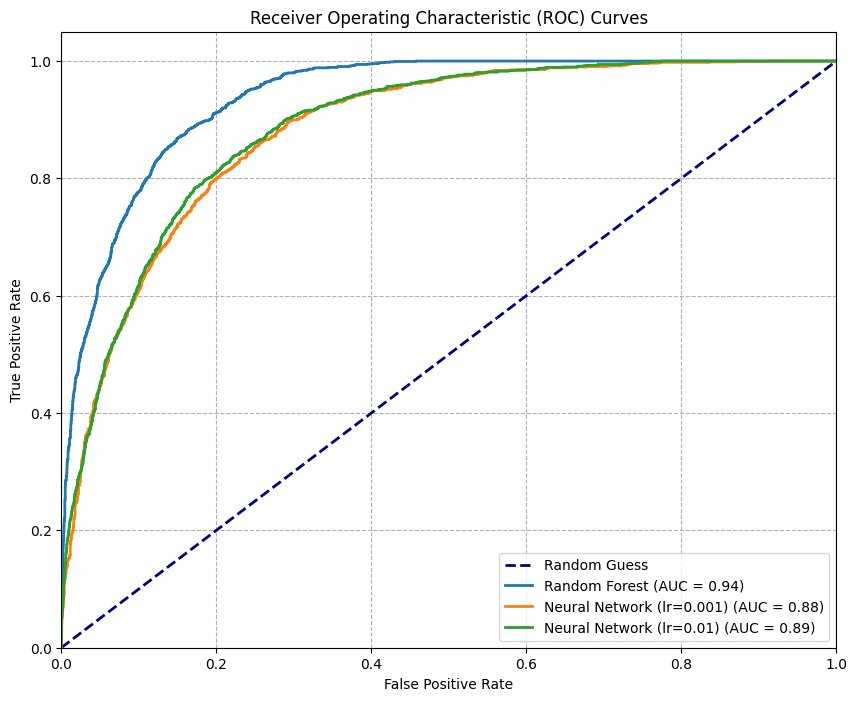

In [27]:
# --- Plot ROC Curves for All Models using the Full Training Set ---

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

for model_name, results in all_results.items():
    best_model = best_estimators[model_name]
    # Get predicted probabilities for positive class using the full training set
    y_proba = best_model.predict_proba(X_train)[:, 1]  # Predict on X_train
    fpr, tpr, thresholds = roc_curve(y_train, y_proba)  # Use y_train
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(axis='both', linestyle='--')
plt.show()

**Best Model:**

* **Neural Network:** This indicates that among the models and hyperparameters tested, the Neural Network with a learning rate of 0.001 performed the best. 
* **Mean ROC AUC:** The average ROC AUC across different cross-validation folds is 0.866. This is a good score, indicating the model has a strong ability to distinguish between the two classes in your data.

**Confusion Matrix:**
* **True Negatives (TN):** 956 instances of the negative class were correctly predicted as negative.
* **False Positives (FP):** 76 instances were incorrectly predicted as negative when they were actually positive.
* **False Negatives (FN):** 182 instances were incorrectly predicted as positive when they were actually negative.
* **True Positives (TP):** 169 instances of the positive class were correctly predicted as positive.

**Classification Report:**
* **Precision (Class 0):** 84% of instances predicted as negative were actually negative.
* **Recall (Class 0):** 93% of all actual negative instances were correctly identified.
* **F1-Score (Class 0):** 0.88 represents a good balance between precision and recall for the negative class.
* **Precision (Class 1):** 69% of instances predicted as positive were actually positive.
* **Recall (Class 1):** 48% of all actual positive instances were correctly identified.
* **F1-Score (Class 1):** 0.57 represents a moderate balance between precision and recall for the positive class.

**Overall Accuracy:**
* **Accuracy:** The model correctly classified 81.3% of all instances.

**Areas for Improvement:**
* **Class Imbalance:** There seems to be some class imbalance, evident from the lower recall for class 1. Consider addressing this using techniques like resampling (oversampling or undersampling) or assigning class weights.
* **Further Hyperparameter Tuning:** You could potentially improve performance by exploring a wider range of hyperparameters for the neural network, such as different numbers of layers, neurons per layer, or activation functions.
* **More Training Data:** If possible, collecting more data (especially for the minority class) can often lead to better model performance.

### GUI (Tkinter)

In [28]:
# Step 1: Load necessary libraries
import os
import tkinter as tk
from tkinter import messagebox
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.pipeline import Pipeline

In [29]:
# Step 2: Load the preprocessor
preprocessor_path = 'data_preprocessor.joblib'
if not os.path.exists(preprocessor_path):
    print(f"Preprocessor file not found at: {preprocessor_path}")
    preprocessor = None
else:
    preprocessor = joblib.load(preprocessor_path)

# Step 3: Load the best model
model_path = 'neural_network_model.keras'
if not os.path.exists(model_path):
    print(f"Model file not found at: {model_path}")
    best_nn_model = None
else:
    best_nn_model = load_model(model_path)


In [34]:
# Step 4: Define the function to predict
def predict():
    if preprocessor is None or best_nn_model is None:
        messagebox.showerror("Error", "Model or preprocessor not loaded.")
        return
    
    try:
        # Collect input data
        input_data = [
            float(entry_tenure.get()),
            float(entry_monthly_charges.get()),
            float(entry_total_charges.get()),
            entry_gender.get(),
            int(entry_senior_citizen.get()),
            entry_partner.get(),
            entry_dependents.get(),
            entry_phone_service.get(),
            entry_multiple_lines.get(),
            entry_internet_service.get(),
            entry_online_security.get(),
            entry_online_backup.get(),
            entry_device_protection.get(),
            entry_tech_support.get(),
            entry_streaming_tv.get(),
            entry_streaming_movies.get(),
            entry_contract.get(),
            entry_paperless_billing.get(),
            entry_payment_method.get()
        ]
        
        # Preprocess the input data
        input_df = pd.DataFrame([input_data], columns=[
            'tenure', 'MonthlyCharges', 'TotalCharges',
            'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod'
        ])
        processed_input = preprocessor.transform(input_df)  # Apply the preprocessor

        # Make prediction
        prediction = best_nn_model.predict(processed_input)
        churn_probability = prediction[0][0]  # Extract the prediction value
        churn_comment = "High likelihood of leaving" if churn_probability > 0.5 else "Low likelihood of leaving"
        # Calculate discount only for those likely to churn
        if churn_probability > 0.5:
            discount_percentage = min(churn_probability * 20, 20)  # Cap the discount at 20%
        else:
            discount_percentage = 0  # No discount for low likelihood of churn

        # Display the results
        messagebox.showinfo("Prediction", f"Predicted value: {churn_probability:.2f}\n"
                                          f"Comment: {churn_comment}\n"
                                          f"Recommended discount: {discount_percentage:.2f}%")
    
    except Exception as e:
        messagebox.showerror("Error", str(e))


In [35]:
# Step 5: Create the main window
root = tk.Tk()
root.title("Telco Customer Churn Prediction")
root.configure(bg='black')

# Create input fields
labels = [
    "Tenure (months)", "Monthly Charges ($)", "Total Charges ($)",
    "Gender (Male/Female)", "Senior Citizen (1/0)", "Partner (Yes/No)",
    "Dependents (Yes/No)", "Phone Service (Yes/No)", "Multiple Lines (Yes/No/No phone service)",
    "Internet Service (DSL/Fiber optic/No)", "Online Security (Yes/No/No internet service)",
    "Online Backup (Yes/No/No internet service)", "Device Protection (Yes/No/No internet service)",
    "Tech Support (Yes/No/No internet service)", "Streaming TV (Yes/No/No internet service)",
    "Streaming Movies (Yes/No/No internet service)", "Contract (Month-to-month/One year/Two year)",
    "Paperless Billing (Yes/No)", "Payment Method (Electronic check/Mailed check/Bank transfer(automatic)/Credit card(automatic))"
]

entries = {}
for label in labels:
    frame = tk.Frame(root, bg='black')
    frame.pack(pady=5, anchor='w')
    lbl = tk.Label(frame, text=label, bg='black', fg='white')
    lbl.pack(side=tk.LEFT)
    entry = tk.Entry(frame, bg='darkgray', fg='black')
    entry.pack(side=tk.RIGHT)
    entries[label] = entry

# Assign entries to variables
(entry_tenure, entry_monthly_charges, entry_total_charges,
 entry_gender, entry_senior_citizen, entry_partner,
 entry_dependents, entry_phone_service, entry_multiple_lines,
 entry_internet_service, entry_online_security, entry_online_backup,
 entry_device_protection, entry_tech_support, entry_streaming_tv,
 entry_streaming_movies, entry_contract, entry_paperless_billing,
 entry_payment_method) = [entries[label] for label in labels]

# Create a predict button
btn_predict = tk.Button(root, text="Predict", command=predict, bg='gray', fg='white')
btn_predict.pack(pady=20)

# Run the application
root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
